In [1]:
import os
import sys
import numpy as np
import pandas as pd
from scipy import misc
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.sparse import csgraph
from scipy import linalg
from pysheds.grid import Grid
from scipy import ndimage
from matplotlib import colors
import seaborn as sns

import matplotlib
import matplotlib.cm as cm
from matplotlib.collections import LineCollection

%matplotlib inline

In [2]:
sns.set_palette('husl', 2)

In [3]:
grid = Grid.from_raster('../../../pysheds/data/n30w100_dir',
                 data_name='dir', input_type='ascii')

In [4]:
grid.read_raster('../../../pysheds/data/n30w100_con',
                 data_name='dem', input_type='ascii')

In [5]:
dirmap = (64,  128,  1,   2,    4,   8,    16,  32)

# Specify pour point
x, y = -97.294167, 32.73750

# Delineate the catchment
grid.catchment(data='dir', x=x, y=y, dirmap=dirmap, out_name='catch',
               recursionlimit=15000, xytype='label')
# Clip the bounding box to the catchment
grid.clip_to('catch', precision=5)

grid.accumulation(data='catch', dirmap=dirmap, pad_inplace=False, out_name='acc')

In [6]:
profiles, connections = grid.extract_profiles('catch', grid.acc > 25)

In [7]:
geom = grid.extract_river_network('catch', grid.acc > 25)

# Advective only

In [8]:
dx = 60. * (np.asarray([profile.size for profile in profiles]) + 1)
n = max(max(connections.keys()), max(connections.values())) + 1
s = np.ones(n)
I = np.eye(n)
u = np.ones(n)
D = 4*np.ones(n)
dt = 1
I[0, 0] = 0

U = np.zeros((n, n))
W = np.zeros((n, n))

for i, j in connections.items():
    # Confirmed as i
    U[j, i] = u[i] * dt / dx[i]
    W[i, j] = u[i] * dt / dx[i]
    
V = np.diag(W @ s)

X = np.zeros((n, n))

for i, j in connections.items():
    X[i, j] = 2 / (dx[i] + dx[j])
    X[j, i] = 2 / (dx[i] + dx[j])
    
Y = np.diag(X @ s)

Z = np.diag(D * dt / dx)
S0 = (U - V) - Z @ (Y - X) + I

In [9]:
(u * dx / D).mean()

98.81165919282512

In [10]:
np.imag(np.linalg.eig(S0)[0]).max(), np.imag(np.linalg.eig(S0)[0]).min(), np.real(np.linalg.eig(S0)[0]).max(), np.real(np.linalg.eig(S0)[0]).min()

(0.0, 0.0, 0.999261974622342, -0.0002801905698907692)

In [11]:
W_os = []
for i in range(len(S0)):
    W_o_i = linalg.solve_discrete_lyapunov(S0.T, I[[i]].T @ I[[i]])
    W_os.append(W_o_i)

In [12]:
Ws = []
ss = []
ns = 6

for i in range(ns):
    rs = np.asarray([np.linalg.matrix_rank(w + sum(Ws)) for w in W_os])
    ix = np.argmax(rs)
    ss.append(ix)
    Ws.append(W_os[ix])

In [13]:
W_c = linalg.solve_discrete_lyapunov(S0, I)
st = np.argsort(np.diag(W_c))[::-1][:6]

In [14]:
ss0 = ss.copy()
st0 = st.copy()

# Lo Diffusion + advection

In [15]:
dx = 60. * (np.asarray([profile.size for profile in profiles]) + 1)
n = max(max(connections.keys()), max(connections.values())) + 1
s = np.ones(n)
I = np.eye(n)
u = np.ones(n)
D = 40*np.ones(n)
dt = 1
I[0, 0] = 0

U = np.zeros((n, n))
W = np.zeros((n, n))

for i, j in connections.items():
    # Confirmed as i
    U[j, i] = u[i] * dt / dx[i]
    W[i, j] = u[i] * dt / dx[i]
    
V = np.diag(W @ s)

X = np.zeros((n, n))

for i, j in connections.items():
    X[i, j] = 2 / (dx[i] + dx[j])
    X[j, i] = 2 / (dx[i] + dx[j])
    
Y = np.diag(X @ s)

Z = np.diag(D * dt / dx)
S1 = (U - V) - Z @ (Y - X) + I

In [16]:
(u * dx / D).mean()

9.88116591928251

In [17]:
np.imag(np.linalg.eig(S1)[0]).max(), np.imag(np.linalg.eig(S1)[0]).min(), np.real(np.linalg.eig(S1)[0]).max(), np.real(np.linalg.eig(S1)[0]).min()

(0.0, 0.0, 0.9997259569184052, -0.0028089938289308823)

In [18]:
W_os = []
for i in range(len(S1)):
    W_o_i = linalg.solve_discrete_lyapunov(S1.T, I[[i]].T @ I[[i]])
    W_os.append(W_o_i)

In [19]:
Ws = []
ss = []
ns = 6

for i in range(ns):
    rs = np.asarray([np.linalg.matrix_rank(w + sum(Ws)) for w in W_os])
    ix = np.argmax(rs)
    ss.append(ix)
    Ws.append(W_os[ix])

In [20]:
W_c = linalg.solve_discrete_lyapunov(S1, I)
st = np.argsort(np.diag(W_c))[::-1][:6]

In [21]:
ss1 = ss.copy()
st1 = st.copy()

# Hi Diffusion + advection

In [22]:
dx = 60. * (np.asarray([profile.size for profile in profiles]) + 1)
n = max(max(connections.keys()), max(connections.values())) + 1
s = np.ones(n)
I = np.eye(n)
u = np.ones(n)
D = 400*np.ones(n)
dt = 1
I[0, 0] = 0

U = np.zeros((n, n))
W = np.zeros((n, n))

for i, j in connections.items():
    # Confirmed as i
    U[j, i] = u[i] * dt / dx[i]
    W[i, j] = u[i] * dt / dx[i]
    
V = np.diag(W @ s)

X = np.zeros((n, n))

for i, j in connections.items():
    X[i, j] = 2 / (dx[i] + dx[j])
    X[j, i] = 2 / (dx[i] + dx[j])
    
Y = np.diag(X @ s)

Z = np.diag(D * dt / dx)
S2 = (U - V) - Z @ (Y - X) + I

In [23]:
(u * dx / D).mean()

0.9881165919282512

In [24]:
np.imag(np.linalg.eig(S2)[0]).max(), np.imag(np.linalg.eig(S2)[0]).min(), np.real(np.linalg.eig(S2)[0]).max(), np.real(np.linalg.eig(S2)[0]).min()

(0.0, 0.0, 1.002400833255208, -0.028819584929342393)

In [25]:
W_os = []
for i in range(len(S2)):
    W_o_i = linalg.solve_discrete_lyapunov(S2.T, I[[i]].T @ I[[i]])
    W_os.append(W_o_i)

In [26]:
Ws = []
ss = []
ns = 6

for i in range(ns):
    rs = np.asarray([np.linalg.matrix_rank(w + sum(Ws)) for w in W_os])
    ix = np.argmax(rs)
    ss.append(ix)
    Ws.append(W_os[ix])

In [27]:
W_c = linalg.solve_discrete_lyapunov(S2, I)
st = np.argsort(np.diag(W_c))[::-1][:6]

In [28]:
ss2 = ss.copy()
st2 = st.copy()

In [29]:
geom2 = grid.extract_river_network('catch', grid.acc > 50)

In [30]:
cmap = sns.cubehelix_palette(rot=0.15, start=0, hue=1, gamma=1.5, dark=0.15, light=0.85, as_cmap=True)

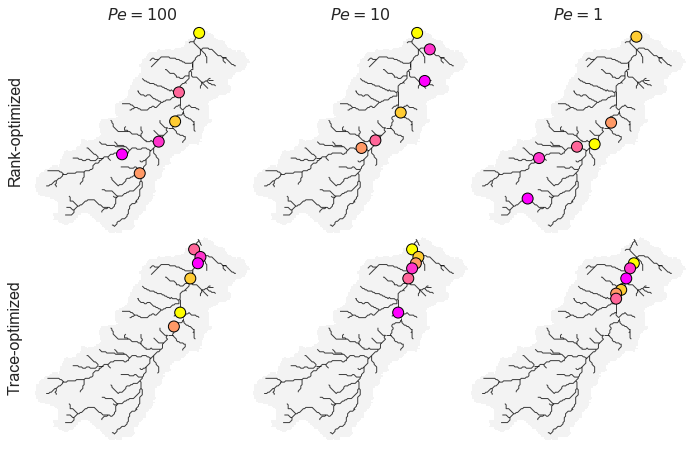

In [31]:
fig, ax = plt.subplots(2, 3, figsize=(10,8))

for i in range(6):
    ax.flat[i].set_facecolor('w')
    ax.flat[i].xaxis.set_ticklabels([])
    ax.flat[i].yaxis.set_ticklabels([])
    
segs = [np.asarray(branch['geometry']['coordinates']) for branch in geom2['features']]
line_segments = LineCollection(segs, color='k', linewidth=1.0, alpha=0.75)
_ = ax.flat[0].add_collection(line_segments)
coords = np.asarray([geom['features'][j]['geometry']['coordinates'][0]
                     for j in ss0])
ax.flat[0].scatter(coords[:,0], coords[:,1], c=np.arange(len(ss0)), zorder=2, cmap='spring_r', s=120, edgecolor='k', linewidth=1)
ax.flat[0].imshow(np.where(grid.view('catch'), 1, np.nan), zorder=1, cmap='Greys',
             vmin=0, vmax=6, extent=grid.extent, alpha=0.5)
ax.flat[0].xaxis.set_ticklabels([])
ax.flat[0].yaxis.set_ticklabels([])
ax.flat[0].set_xlim(grid.extent[0] - 0.001, grid.extent[1] + 0.001)
ax.flat[0].set_ylim(grid.extent[2] - 0.001, grid.extent[3] + 0.003)

segs = [np.asarray(branch['geometry']['coordinates']) for branch in geom2['features']]
line_segments = LineCollection(segs, color='k', linewidth=1.0, alpha=0.75)
_ = ax.flat[1].add_collection(line_segments)
coords = np.asarray([geom['features'][j]['geometry']['coordinates'][0]
                     for j in ss1])
ax.flat[1].scatter(coords[:,0], coords[:,1], c=np.arange(len(ss1)), zorder=2, cmap='spring_r', s=120, edgecolor='k', linewidth=1)
ax.flat[1].imshow(np.where(grid.view('catch'), 1, np.nan), zorder=1, cmap='Greys',
             vmin=0, vmax=6, extent=grid.extent, alpha=0.5)
ax.flat[1].xaxis.set_ticklabels([])
ax.flat[1].yaxis.set_ticklabels([])
ax.flat[1].set_xlim(grid.extent[0] - 0.001, grid.extent[1] + 0.001)
ax.flat[1].set_ylim(grid.extent[2] - 0.001, grid.extent[3] + 0.003)

segs = [np.asarray(branch['geometry']['coordinates']) for branch in geom2['features']]
line_segments = LineCollection(segs, color='k', linewidth=1.0, alpha=0.75)
_ = ax.flat[2].add_collection(line_segments)
coords = np.asarray([geom['features'][j]['geometry']['coordinates'][0]
                     for j in ss2])
ax.flat[2].scatter(coords[:,0], coords[:,1], c=np.arange(len(ss2)), zorder=2, cmap='spring_r', s=120, edgecolor='k', linewidth=1)
ax.flat[2].imshow(np.where(grid.view('catch'), 1, np.nan), zorder=1, cmap='Greys',
             vmin=0, vmax=6, extent=grid.extent, alpha=0.5)
ax.flat[2].xaxis.set_ticklabels([])
ax.flat[2].yaxis.set_ticklabels([])
ax.flat[2].set_xlim(grid.extent[0] - 0.001, grid.extent[1] + 0.001)
ax.flat[2].set_ylim(grid.extent[2] - 0.001, grid.extent[3] + 0.003)

segs = [np.asarray(branch['geometry']['coordinates']) for branch in geom2['features']]
line_segments = LineCollection(segs, color='k', linewidth=1.0, alpha=0.75)
_ = ax.flat[3].add_collection(line_segments)
coords = np.asarray([geom['features'][j]['geometry']['coordinates'][0]
                     for j in st0])
ax.flat[3].scatter(coords[:,0], coords[:,1], c=np.arange(len(st0)), zorder=2, cmap='spring_r', s=120, edgecolor='k', linewidth=1)
ax.flat[3].imshow(np.where(grid.view('catch'), 1, np.nan), zorder=1, cmap='Greys',
             vmin=0, vmax=6, extent=grid.extent, alpha=0.5)
ax.flat[3].xaxis.set_ticklabels([])
ax.flat[3].yaxis.set_ticklabels([])
ax.flat[3].set_xlim(grid.extent[0] - 0.001, grid.extent[1] + 0.001)
ax.flat[3].set_ylim(grid.extent[2] - 0.001, grid.extent[3] + 0.003)

segs = [np.asarray(branch['geometry']['coordinates']) for branch in geom2['features']]
line_segments = LineCollection(segs, color='k', linewidth=1.0, alpha=0.75)
_ = ax.flat[4].add_collection(line_segments)
coords = np.asarray([geom['features'][j]['geometry']['coordinates'][0]
                     for j in st1])
ax.flat[4].scatter(coords[:,0], coords[:,1], c=np.arange(len(st1)), zorder=2, cmap='spring_r', s=120, edgecolor='k', linewidth=1)
ax.flat[4].imshow(np.where(grid.view('catch'), 1, np.nan), zorder=1, cmap='Greys',
             vmin=0, vmax=6, extent=grid.extent, alpha=0.5)
ax.flat[4].xaxis.set_ticklabels([])
ax.flat[4].yaxis.set_ticklabels([])
ax.flat[4].set_xlim(grid.extent[0] - 0.001, grid.extent[1] + 0.001)
ax.flat[4].set_ylim(grid.extent[2] - 0.001, grid.extent[3] + 0.003)

segs = [np.asarray(branch['geometry']['coordinates']) for branch in geom2['features']]
line_segments = LineCollection(segs, color='k', linewidth=1.0, alpha=0.75)
_ = ax.flat[5].add_collection(line_segments)
coords = np.asarray([geom['features'][j]['geometry']['coordinates'][0]
                     for j in st2])
ax.flat[5].scatter(coords[:,0], coords[:,1], c=np.arange(len(st2)), zorder=2, cmap='spring_r', s=120, edgecolor='k', linewidth=1)
ax.flat[5].imshow(np.where(grid.view('catch'), 1, np.nan), zorder=1, cmap='Greys',
             vmin=0, vmax=6, extent=grid.extent, alpha=0.5)
ax.flat[5].xaxis.set_ticklabels([])
ax.flat[5].yaxis.set_ticklabels([])
ax.flat[5].set_xlim(grid.extent[0] - 0.001, grid.extent[1] + 0.001)
ax.flat[5].set_ylim(grid.extent[2] - 0.001, grid.extent[3] + 0.003)

ax.flat[0].set_ylabel('Rank-optimized', size=16)
ax.flat[3].set_ylabel('Trace-optimized', size=16)

ax.flat[0].set_title('$Pe = 100$', size=16)
ax.flat[1].set_title('$Pe = 10$', size=16)
ax.flat[2].set_title('$Pe = 1$', size=16)

plt.tight_layout(pad=2.0, h_pad=-8.0, w_pad=0)
#plt.savefig('placements-by-peclet-number.png', bbox_inches='tight')